/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sample Average IoU: 0.7189164766594758
Sample Average IoU: 0.7851787811976567
Sample Average IoU: 0.7470228598706998
Sample Average IoU: 0.7499160516488338


Sample Average IoU: 0.7607111719361546


Sample Average IoU: 0.7543786165949554
Sample Average IoU: 0.7761598541429576
Sample Average IoU: 0.7779180128690206


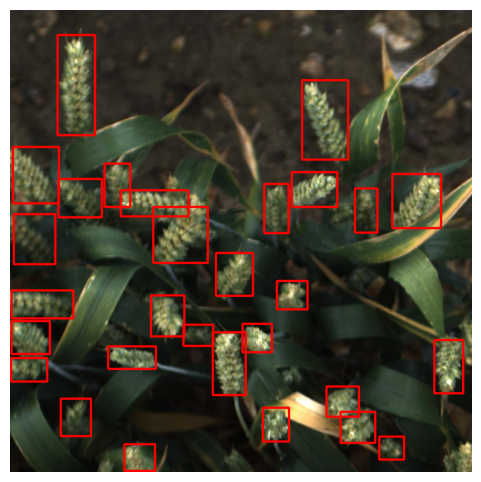

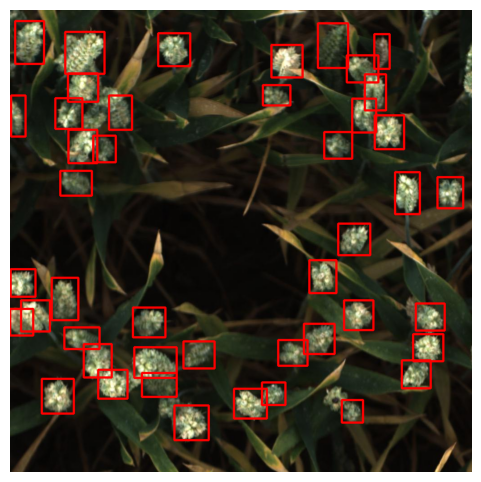

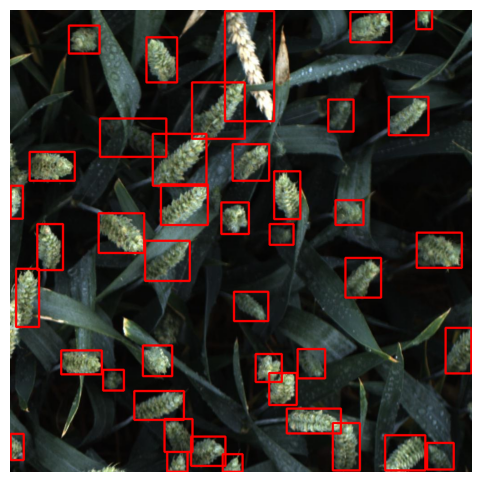

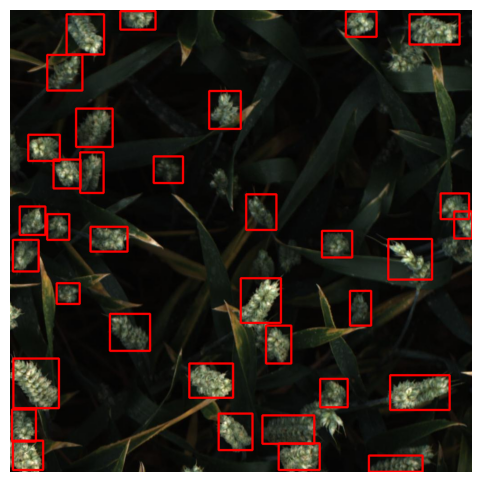

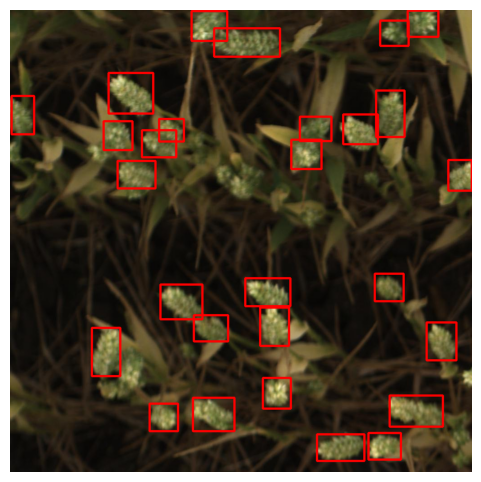

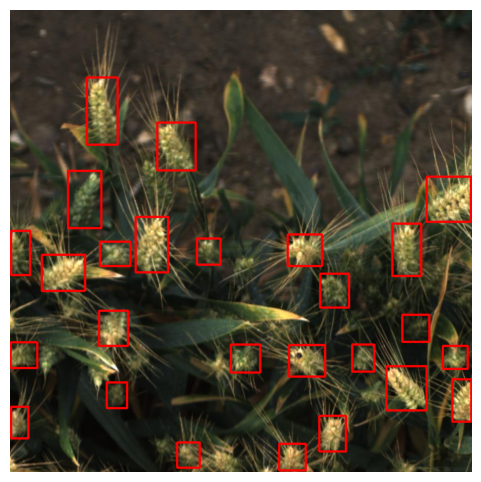

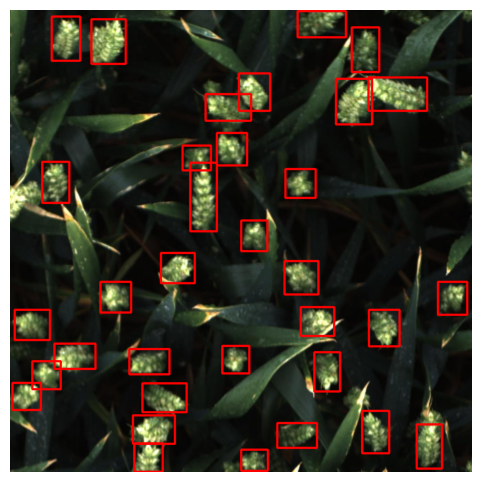

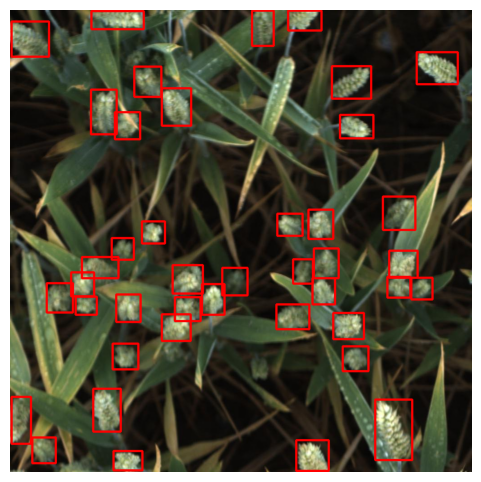

In [3]:
import pandas as pd
import numpy as np
import cv2
import albumentations as A
import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader, Dataset

from matplotlib import pyplot as plt

def tensor_transform():
    """
    This method converts loaded image to tensor form
    """
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def collate_fn(batch):
    """
    This method return's sample of batch in form of tuple
    """
    return tuple(zip(*batch))

def calculate_area_boxes(boxes):
    boxes[:, 2] = boxes[:, 0] + boxes[:, 2]
    boxes[:, 3] = boxes[:, 1] + boxes[:, 3]

    return (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

def train_model(model,device,train_data_loader,num_epochs,model_optimizer):
  model.to(device)

  optimizer = model_optimizer
  epoch_loss = []

  for epoch in range(num_epochs):
      batch_losses = []
      for images, targets, image_ids in train_data_loader:
          
          images = list(image.to(device) for image in images)
          targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

          loss_dict = model(images, targets)

          losses = sum(loss for loss in loss_dict.values())
          loss_value = losses.item()
          batch_losses.append(loss_value)

          optimizer.zero_grad()
          losses.backward()
          optimizer.step()

          print("Batch Loss = {}".format(loss_value))

      epoch_loss.append(sum(batch_losses) / len(batch_losses))
      
      print("Epoch Loss = {}".format(sum(batch_losses)/len(batch_losses)))
      return model,epoch_loss

def plot_loss_per_epoch(loss_values):
    """
    Plot the loss values per epoch.
    """
    epochs = range(1, len(loss_values) + 1)

    plt.plot(epochs, loss_values)
    plt.xlabel('Number of Epochs')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.grid(True)
    plt.show()
def calculate_iou(box1, box2):
    """
    This function calculates the Intersection over Union (IoU) between two bounding boxes.
    """
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area

    iou = intersection_area / union_area

    return iou

def show_predicted_images_with_bbox(sample,c_boxes):
  fig, ax = plt.subplots(1, 1, figsize=(6, 6))
      
  for box in c_boxes:
    t_l = (box[0], box[1])
    b_r = (box[2], box[3])
    cv2.rectangle(sample,t_l,b_r ,(220, 0, 0), 3)
      
  ax.set_axis_off()
  ax.imshow(sample)
  
def validate_model(device,model,valid_data_loader):
  iou_sample = []
  model.to(device).eval()
  cpu_device = torch.device("cpu")
  images, targets, image_ids = next(iter(valid_data_loader))
  images = list(img.to(device) for img in images)
  targets = [{k: v.to(device) for k, v in t.items()} for t in targets] 
  outputs = model(images)
  outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
  for sample_no in range(len(images)):
    boxes = targets[sample_no]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[sample_no].permute(1,2,0).cpu().numpy()
    scores = outputs[sample_no]['scores']
  
    b_boxes = outputs[sample_no]['boxes'].detach().numpy()
    b_boxes = b_boxes.astype(int)
    c_boxes = []
    for bbox,score in zip(b_boxes,scores):
      if score>0.8:
        c_boxes.append(bbox)
    show_predicted_images_with_bbox(sample,c_boxes)
    ious = []
    predicted_boxes = c_boxes  
    ground_truth_boxes = boxes 

    for pred_box in predicted_boxes:
        ious_ = []
        for gt_box in ground_truth_boxes:
            iou = calculate_iou(pred_box, gt_box)
            ious_.append(iou)
        ious.append(max(ious_))
    average_iou = sum(ious) / len(ious)
    print("Sample Average IoU: {}".format(average_iou))
    iou_sample.append(average_iou)
  return iou_sample

class WheatDataset(Dataset):

    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        self.transforms = transforms
        self.df = dataframe
        self.image_dir = image_dir
        # each image_id is assosiated with multiple bounding boxes so getting only uniques values
        self.image_ids = dataframe['image_id'].unique()


    def __getitem__(self, index: int):

        image_id = self.image_ids[index]
        boxes_df = self.df[self.df['image_id'] == image_id]
        # read image using cv2 module
        image_path = '{}/{}.jpg'.format(self.image_dir,image_id)
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        # Converting image to numpy array
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        # Normalizing image by dividing each pixel value by 255
        image /= 255.0
        # Bounding boxes are stored in form of list of type string
        # Converting bounding boxes values into numpy arrays
        boxes_n = []
        for box in boxes_df['bbox']:
            boxes_n.append(np.fromstring(box[1:-1], dtype=float, sep=',').astype(int))

        boxes = np.array(boxes_n)

        area = torch.as_tensor(calculate_area_boxes(boxes), dtype=torch.float32)
        # We have only one class (wheat heads) in our dataset
        labels = torch.ones((boxes_df.shape[0],), dtype=torch.int64)

        # we are assuming that all instances are not crowded
        is_crowd = torch.zeros((boxes_df.shape[0],), dtype=torch.int64)
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([index])
        target['area'] = area
        target['iscrowd'] = is_crowd

        sample = {
            'image': image,
            'bboxes': target['boxes'],
            'labels': labels
        }
        # Converting sample's type to tensor by applying transform
        sample = self.transforms(**sample)
        image = sample['image']
        # Converting datatype of boxes to tensor
        tensor_boxes = map(torch.tensor, zip(*sample['bboxes']))
        # Creating boxes inform of tuples
        target['boxes'] = torch.stack(tuple(tensor_boxes)).permute(1, 0)

        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

def load_saved_model(model,weights_path):
  # Load the weights
  model.load_state_dict(torch.load(weights_path))
  return model

def save_model(model):
  torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')


def main_method():

  dataset_path = '/content/drive/MyDrive/global-wheat-detection/'
  train_images_path = '{}/train'.format(dataset_path)
  test_images_path = '{}/test'.format(dataset_path)
  training = False
  testing = True
  # Loading csv file of training data
  train_df = pd.read_csv('{}/train.csv'.format(dataset_path))

  image_ids = train_df['image_id'].unique()

  #Splitting dataset (Using last 500 images for validation dataset)
  valid_df = train_df[train_df['image_id'].isin(image_ids[-500:])]
  train_df = train_df[train_df['image_id'].isin(image_ids[:-500])]
  train_dataset = WheatDataset(train_df, train_images_path, tensor_transform())
  valid_dataset = WheatDataset(valid_df, train_images_path, tensor_transform())

  train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=False, num_workers=4, collate_fn=collate_fn)

  valid_data_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False, num_workers=4, collate_fn=collate_fn)

  #Loading Pre-Trained FasterRCNN model which uses resnet50 as its backbone 
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

  # Using GPU if its available
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

  params = []
  for p in model.parameters():
    if p.requires_grad:
      params.append(p)

  model_optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.1, weight_decay=0.0005)
  num_epochs = 1
  if training is True:
    # Trian model
    model,epoch_loss = train_model(model,device,train_data_loader,num_epochs,model_optimizer)
    # Plot loss curve
    plot_loss_per_epoch(epoch_loss)
    save_model(model)
  if testing is True:
    weights_path = '/content/drive/MyDrive/model_weights/fasterrcnn_resnet50_fpn (1).pth'
    model = load_saved_model(model,weights_path)
    # Validate Model (Find IoU values for samples and also plot samples with bounding boxes)
    validate_model(device,model,valid_data_loader)
if __name__ == '__main__':
  main_method()